In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import time
import pandas as pd
%matplotlib inline

In [5]:
path = "./data"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

data_image = {x:datasets.ImageFolder(root = os.path.join(path,x),
                                     transform = transform[x])
              for x in ["train", "val"]}

data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                num_workers=4,
                                                batch_size=24,
                                                pin_memory=True,
                                                shuffle = True)
                     for x in ["train", "val"]}

dataset_sizes = {x: len(data_image[x]) for x in ['train', 'val']}

/usr/local/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
/usr/local/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [3]:
dataset_sizes
print(u"训练集个数:", dataset_sizes["train"])
print(u"验证集个数:", dataset_sizes["val"])

训练集个数: 22500
验证集个数: 2500


In [6]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [8]:
class_names = data_image['train'].classes
classes_index = data_image["train"].class_to_idx
# print(classes)
print(class_names)

['cat', 'dog']


In [9]:
print(u"训练集个数:", len(data_image["train"]))
print(u"验证集个数:", len(data_image["val"]))

训练集个数: 22500
验证集个数: 2500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


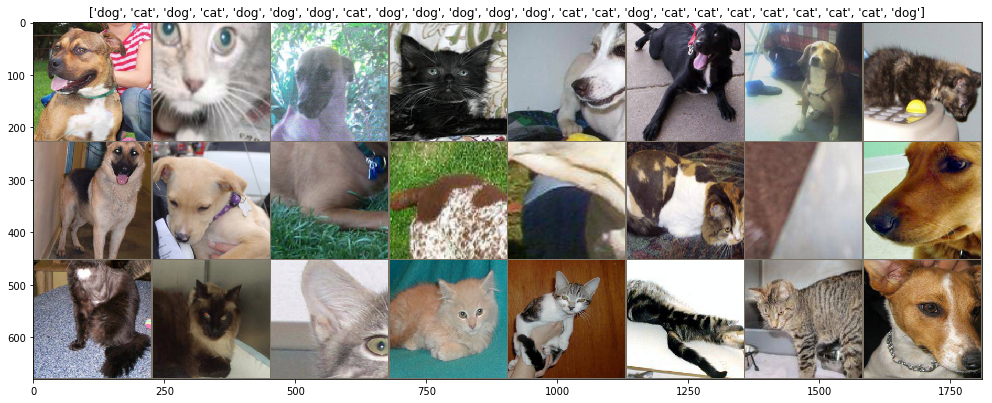

In [10]:
def imshow(inp, title=None):
    """显示Tensor类型的图片"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.figure(figsize=(17, 10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    

#一批训练集
inputs, classes = next(iter(data_loader_image['train']))

#对图片制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[i] for i in classes])



In [98]:
rst = {
    'train':[],
    'val':[]
      }

In [99]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每一轮都有一次训练和验证
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # 将模型设置为训练模式
            else:
                model.train(False)  # 将模型设置为验证模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for data in data_loader_image[phase]:
                # 得到输入数据
                inputs, labels = data

                # 将他们包装在Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # 梯度归零
                optimizer.zero_grad()

                # 前向传播
                outputs = model(inputs) #1
                _, preds = torch.max(outputs.data, 1) #2
                loss = criterion(outputs, labels)

                # 反向传播+参数优化，如果是处于训练时期
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 对每次迭代的loss和accuracy求和
                running_loss += loss.data[0] 
                running_corrects += torch.sum(preds == labels.data)
            # 统计每一轮的平均loss和accuracy   
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            rst[phase].append({'loss':epoch_loss, 'acc':epoch_acc})
            
            # 保存最好的模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
            print()
            
        now_time = time.time() - since   
        print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载模型权重
    model.load_state_dict(best_model_wts) # 3
    return model


In [12]:
import torchvision.models as models
model_names = sorted(name for name in models.__dict__ if name.islower() and not name.startswith("__"))
model_names

['alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'inception',
 'inception_v3',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [11]:
arch = 'resnet101'

In [13]:
model_conv = models.__dict__[arch](pretrained=True)

In [16]:
# 调整模型

for param in model_conv.parameters():
    param.requires_grad = False

# 新加的层默认设置 requires_grad=True 
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2) # 在resnet10之后增加一个全连接层

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# 仅仅优化最后一层的参数
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)


# 每隔7轮学习率变为原来的0.1倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, 
                                       step_size=7, 
                                       gamma=0.1)

In [ ]:
model_conv

In [100]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.0048 Acc: 0.9521

val Loss: 0.0013 Acc: 0.9884

Training time is:1m 9s
Epoch 1/2
----------
train Loss: 0.0048 Acc: 0.9519

val Loss: 0.0014 Acc: 0.9888

Training time is:1m 11s
Epoch 2/2
----------
train Loss: 0.0050 Acc: 0.9489

val Loss: 0.0013 Acc: 0.9896

Training time is:1m 9s
Training complete in 1m 9s
Best val Acc: 0.989600


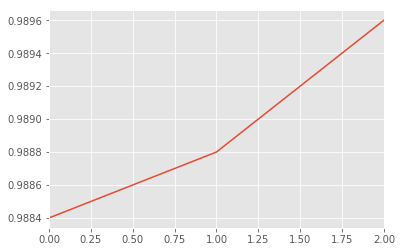

In [110]:
plt.style.use('ggplot')
pd.DataFrame(rst['val'])['acc'].plot()

In [ ]:
rst['val']

In [55]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    # next(iter(data_loader_image['train']))
    for i, data in enumerate(data_loader_image['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            imshow(inputs.cpu().data[j],'predicted: {}'.format(class_names[preds[j]]))
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

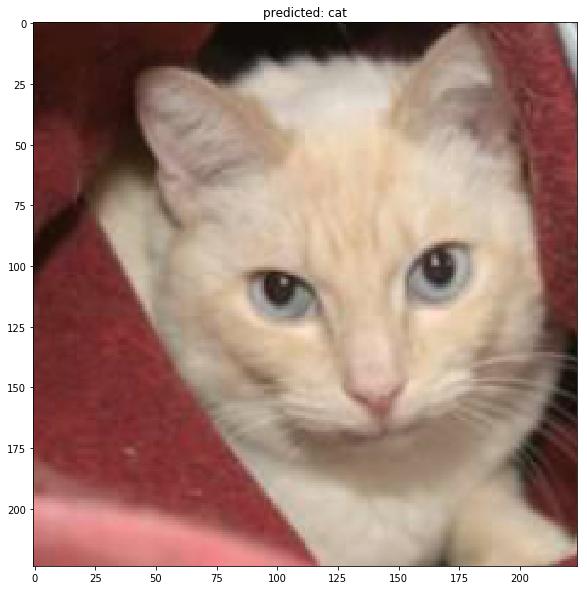

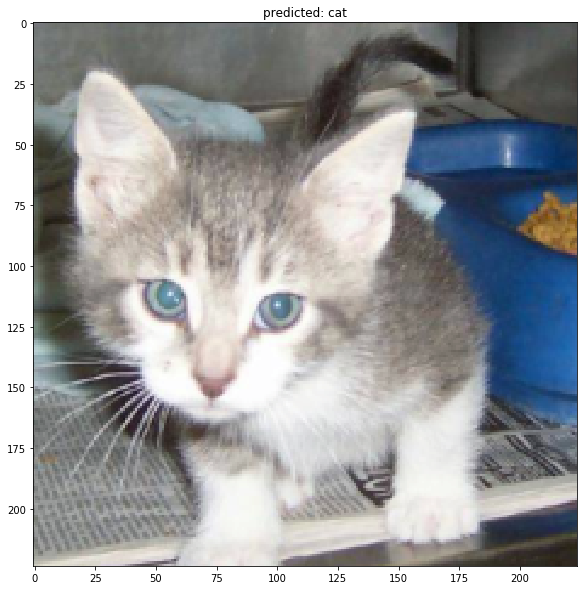

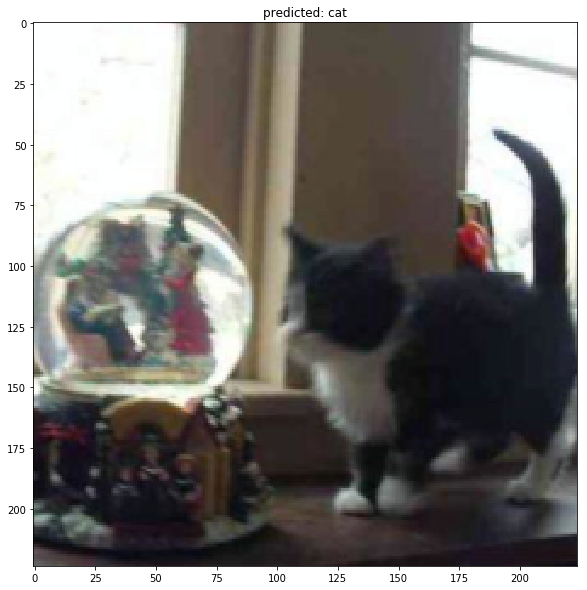

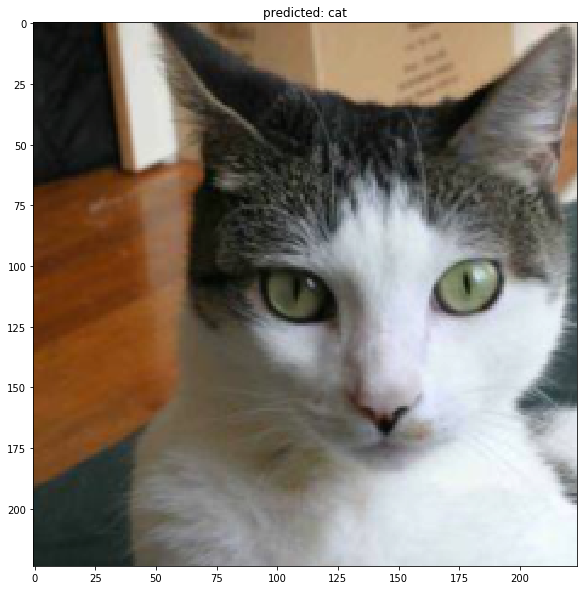

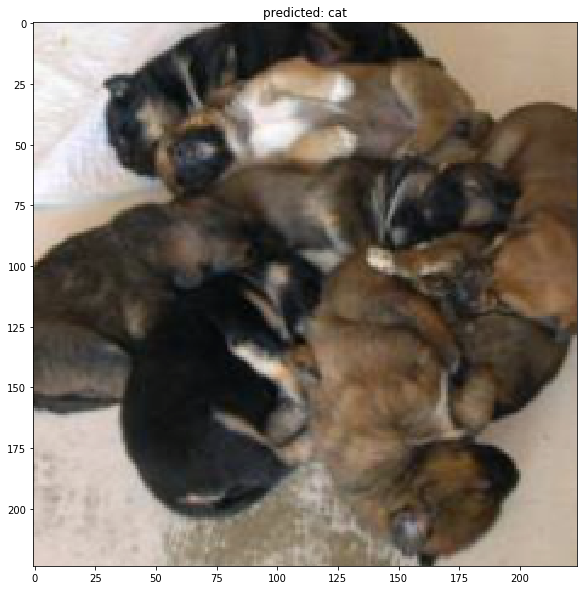

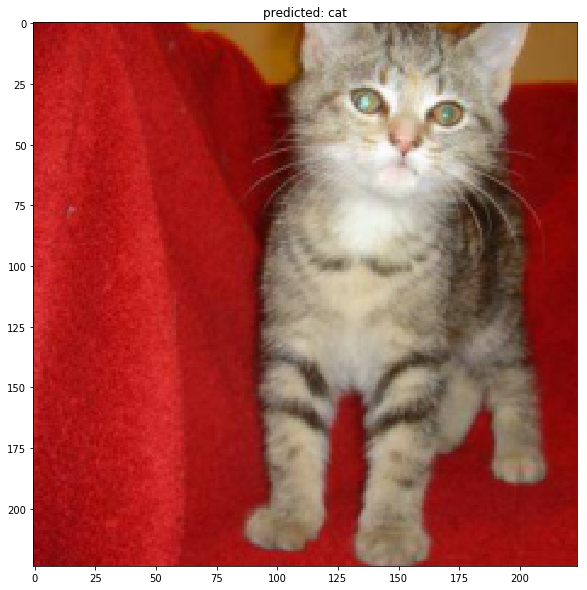

In [56]:
visualize_model(model_conv)


In [ ]:
torch.save(model_conv.state_dict(), "model_%s_finetune.pkl" % arch)

In [ ]:
model.load_state_dict(torch.load('model_%s_finetune.pkl' % arch))

In [ ]:
dir(torch)

In [18]:
class ImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, path
    

In [19]:
data_test_img = ImageFolder(root="./test/",
                                     transform = transform['val'])
data_loader_test_img = torch.utils.data.DataLoader(dataset=data_test_img,
                                                   batch_size = 1)

In [21]:
import collections
clip = 0.005
cnt = 1
csv_map = {}

for image, label, path in data_loader_test_img:
    images = Variable(image.cuda())
    y_pred = model_conv(images)
    smax = torch.nn.Softmax()
    smax_out = smax(y_pred)[0]
    cat_prob = smax_out.data[0]
    dog_prob = smax_out.data[1]
    prob = dog_prob

    if cat_prob > dog_prob:
        prob = 1 - cat_prob
    prob = np.around(prob, decimals=4)
    prob = np.clip(prob, clip, 1-clip)
    filepath = path[0].split('/')[-1].split('.')[-2]
    
    csv_map[filepath] = prob
    


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [22]:
csv_list = []
for k,v in csv_map.items():
    csv_list.append((k,v))

len(csv_list)

12500

In [23]:
df = pd.DataFrame(csv_list)
df.columns = ['id','label']
df.id = df.id.astype(int)
df = df.sort_values('id')

In [24]:
df.to_csv('result_%s.csv' % arch,index=False)

In [25]:
'result_%s.csv' % arch

'result_resnet101.csv'

In [ ]:
df.groupby('id').count()